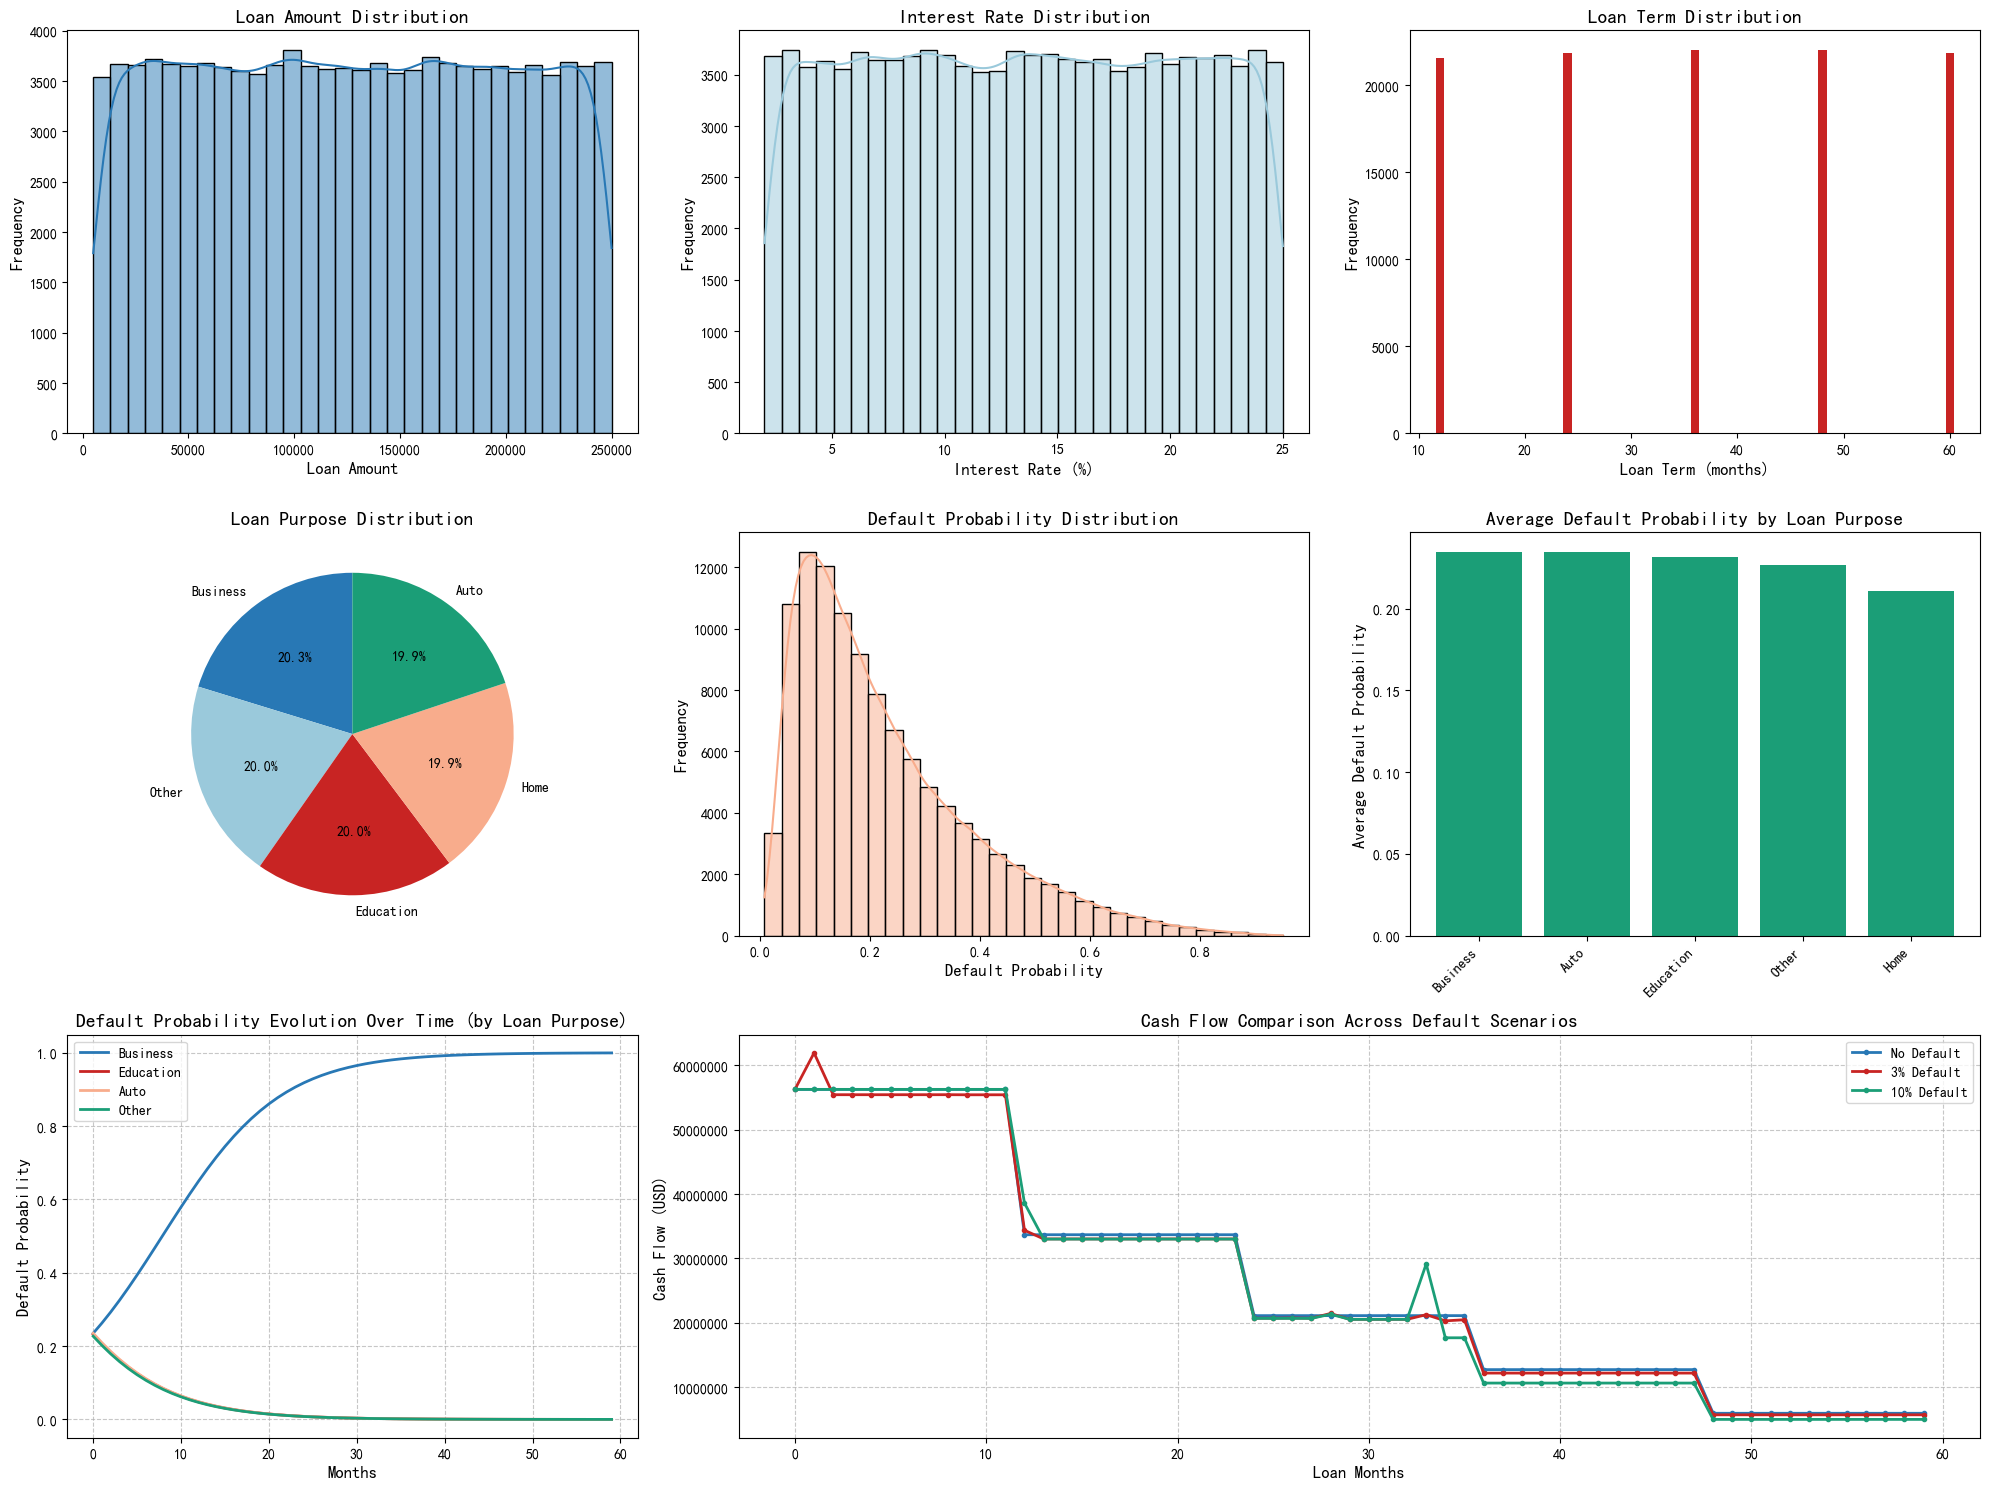

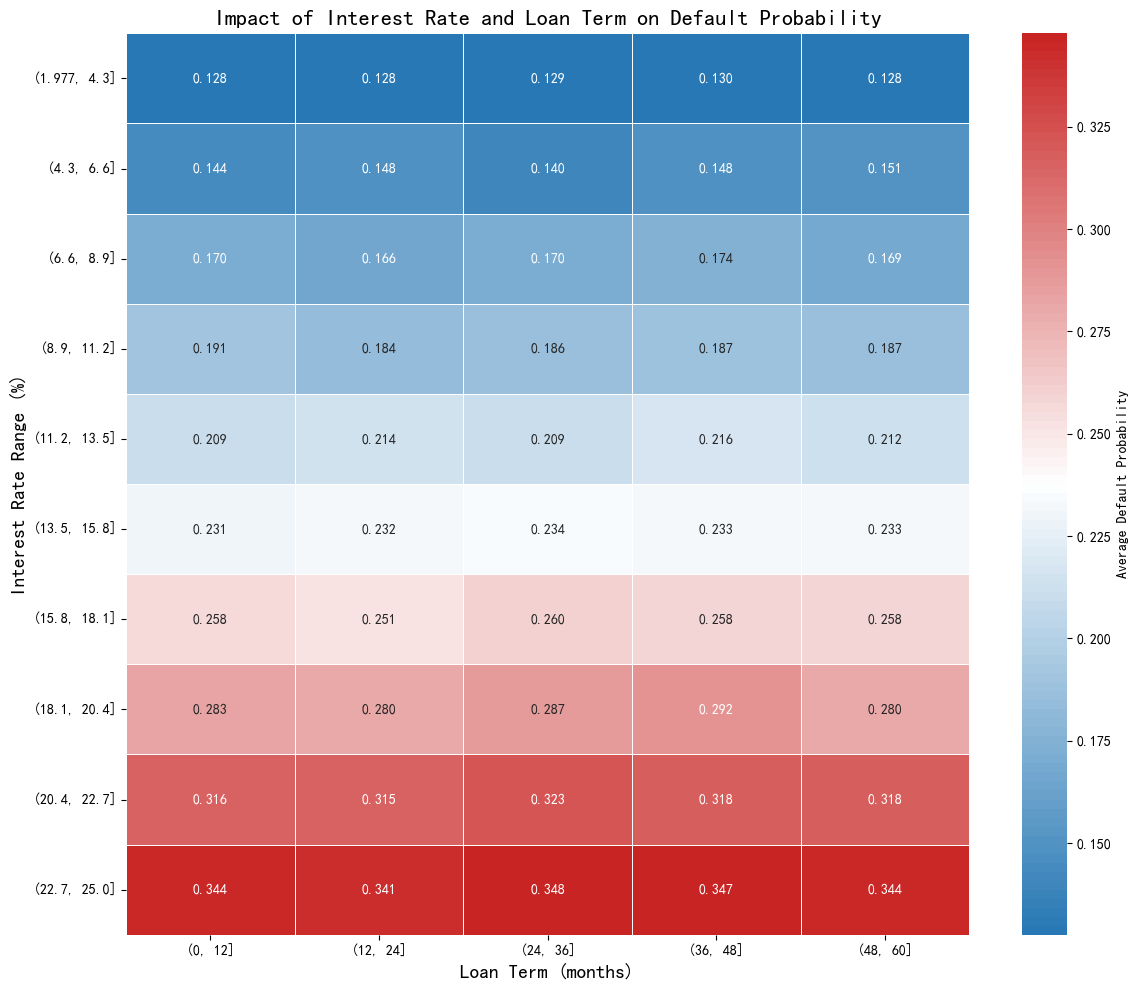

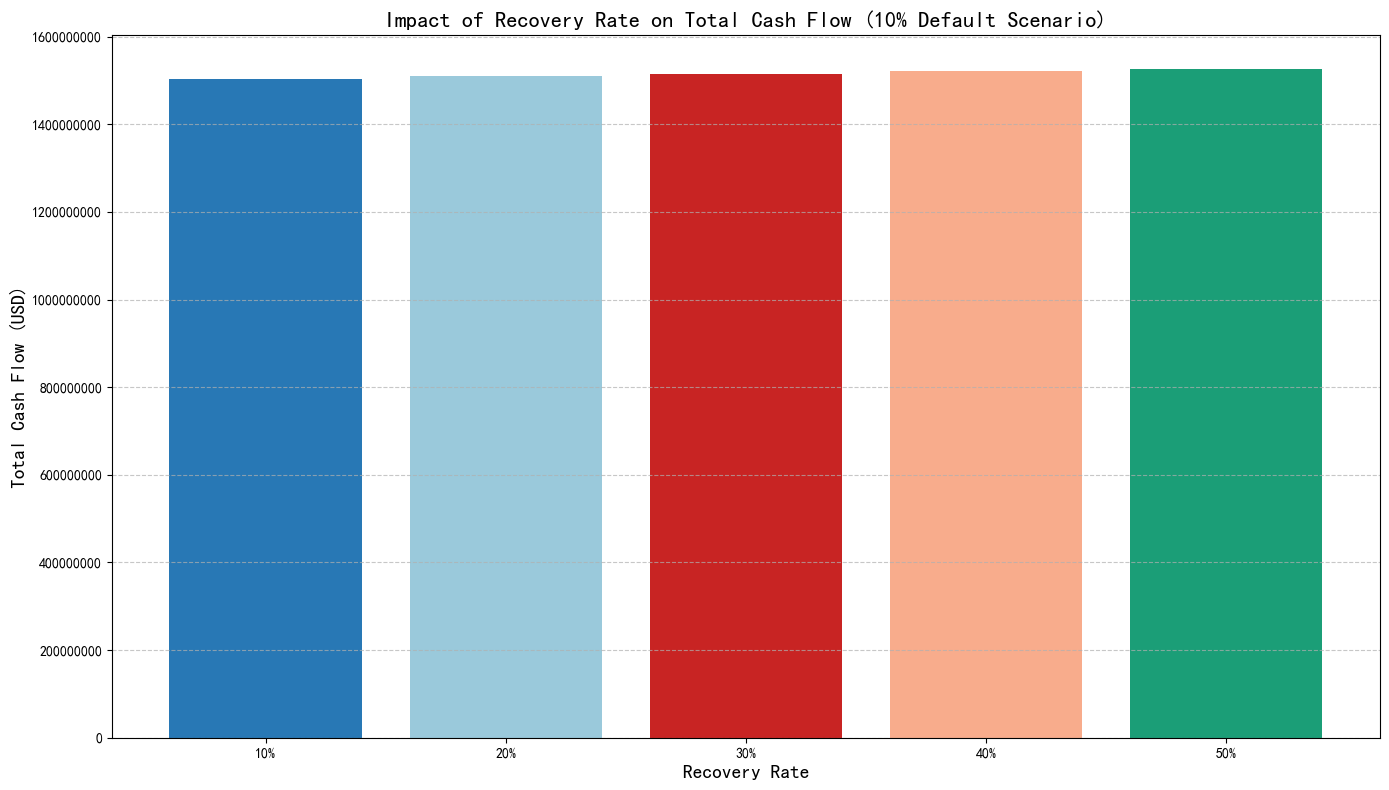

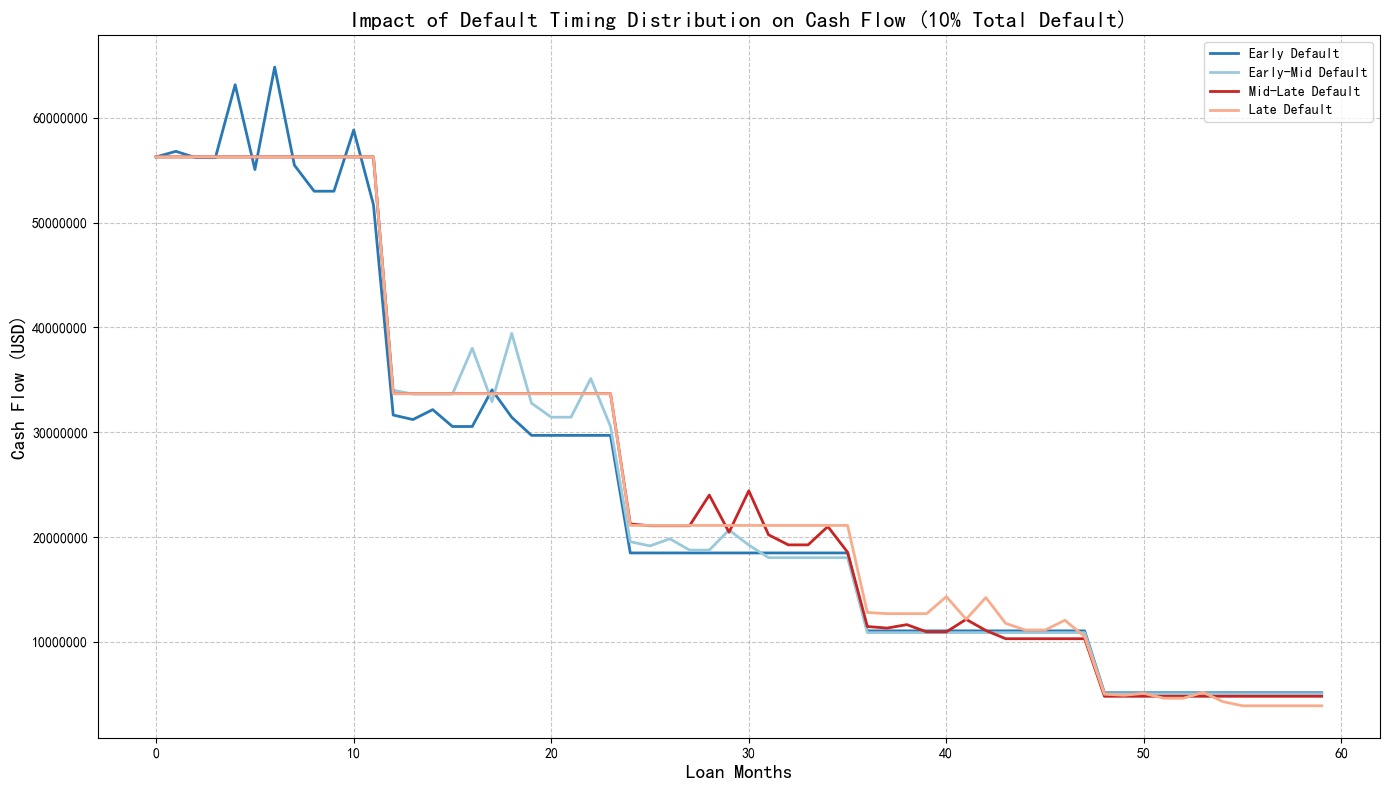

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import random
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['axes.formatter.use_locale'] = True

# 自定义配色
colors = ["#2878B5", "#9AC9DB", "#C82423", "#F8AC8C", "#1B9E77", "#D95F02", "#7570B3"]

# 读取数据
df = pd.read_csv(r"D:\a_543_ASS\543-Loan-Project--main\543-Loan-Project--main\test_predicted.csv")

# 创建贷款数据子集
loan_data = df[["LoanAmount", "InterestRate", "LoanTerm", "LoanPurpose", "DefaultProbability"]]

# 计算月供和未来值
def monthly_payment(P, annual_rate, months):
    r_m = annual_rate / 12 / 100  # 转换为月利率和小数形式
    n = months
    # 摊销贷款公式
    M = P * (r_m * (1 + r_m) ** n) / ((1 + r_m) ** n - 1)
    return M

def future_value(monthly_payments, months):
    return monthly_payments * months

# 添加月供和未来值列
loan_data['MonthlyPayment'] = 0.0
loan_data['FutureValue'] = 0.0

for i in range(loan_data.shape[0]):
    principal = loan_data.loc[i, "LoanAmount"]
    annual_rate = loan_data.loc[i, "InterestRate"]
    months = loan_data.loc[i, "LoanTerm"]
    loan_data.loc[i, "MonthlyPayment"] = monthly_payment(principal, annual_rate, months)
    loan_data.loc[i, 'FutureValue'] = future_value(loan_data.loc[i, "MonthlyPayment"], months)

# 添加贷款结束标记
loan_data['Loan_end_boolean'] = np.zeros(loan_data.shape[0], dtype=bool)

# 模拟设置
def calculate_pd_matrix(loan_data, rate, max_term):
    """向量化PD计算"""
    is_business = (loan_data["LoanPurpose"] == "Business").values
    pd0 = loan_data["DefaultProbability"].values
    loan_terms = loan_data["LoanTerm"].values
    
    # 创建时间网格 [max_term x n_loans]
    t = np.arange(max_term)[:, np.newaxis]
    active_mask = t < loan_terms  # [max_term x n_loans]
    
    # 初始化PD矩阵
    pd_matrix = np.zeros((max_term, len(loan_data)))
    
    # 商业贷款: PD增长到1
    business_mask = active_mask & is_business
    exponent_biz = -rate * t
    pd_matrix[business_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_biz))[business_mask]
    
    # 非商业贷款: PD衰减到0
    non_biz_mask = active_mask & ~is_business
    exponent_non_biz = rate * t
    pd_matrix[non_biz_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_non_biz))[non_biz_mask]
    
    return pd_matrix

def simulate_cashflows(data, rate=0.1, recovery_rate=0.2, default_events=None, rng=None):
    loan_data = data.copy()
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
    
    max_term = loan_data["LoanTerm"].max()
    cashflow_matrix = np.zeros((max_term, len(loan_data)))
    loan_ended = loan_data["Loan_end_boolean"].values.copy()
    pd_matrix = calculate_pd_matrix(loan_data, rate, max_term)
    
    # 转换default_events为字典以便快速查找
    event_dict = dict(default_events) if default_events else {}

    for t in range(max_term):
        active_mask = (~loan_ended) & (t < loan_data["LoanTerm"].values)
        active_idx = np.where(active_mask)[0]
        
        if len(active_idx) == 0:
            continue
            
        current_pd = pd_matrix[t, active_idx]
        sum_pd = current_pd.sum()
        # 获取该时间点的违约数量（如果未指定则为0）
        n_defaults = event_dict.get(t, 0)
        n_defaults = min(n_defaults, len(active_idx))  # 违约不能超过活跃贷款数
        
        if n_defaults > 0 and sum_pd > 1e-8:
            # 基于PD权重的选择
            weights = current_pd / sum_pd
            weights /= weights.sum()  # 确保权重和为1
            chosen = rng.choice(active_idx, size=int(n_defaults), replace=False, p=weights)
            # 计算回收
            fv = loan_data["FutureValue"].values[chosen]
            pmt = loan_data["MonthlyPayment"].values[chosen]
            cashflow_matrix[t, chosen] = (fv - (t)*pmt) * recovery_rate
            loan_ended[chosen] = True
            # 非违约贷款的正常还款
            non_default = np.setdiff1d(active_idx, chosen)
            cashflow_matrix[t, non_default] = loan_data["MonthlyPayment"].values[non_default]
        else:
            cashflow_matrix[t, active_idx] = loan_data["MonthlyPayment"].values[active_idx]
    
    loan_data["Loan_end_boolean"] = loan_ended
    return cashflow_matrix, pd_matrix

def default_schedule_generation(loan_data, num_default_times, total_percent, 
                              peak_center=24, peak_std=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
        
    max_term = loan_data["LoanTerm"].max()
    # 生成默认时间，使用正态分布
    times = []
    while len(times) < num_default_times:
        new_times = rng.normal(loc=peak_center, scale=peak_std, 
                            size=num_default_times - len(times))
        new_times = np.clip(np.round(new_times), 1, max_term).astype(int)
        times = list(np.unique(np.concatenate([times, new_times]) if times else new_times))
    
    # 使用狄利克雷分布分配百分比
    proportions = rng.dirichlet(np.ones(num_default_times))
    percentages = proportions * total_percent
    people_default_num = (percentages/100) * loan_data.shape[0]
    
    for i in range(len(people_default_num)):
        people_default_num[i] = max(int(people_default_num[i]) - 1, 1)
        
    return sorted(zip(times, people_default_num), key=lambda x: x[0])

# 运行模拟
# 生成3个违约场景：无违约、3%违约、10%违约
sample_size = min(10000, len(loan_data))  # 使用抽样来加速计算
loan_sample = loan_data.sample(sample_size, random_state=42)

# 无违约场景
results_no_defaults, pd_matrix_no = simulate_cashflows(
    loan_sample,
    rate=0.15,
    recovery_rate=0.3,
)
no_default_data = np.sum(results_no_defaults, axis=1)

# 3% 违约场景
default_schedule_rand_3 = default_schedule_generation(
    loan_sample, 
    num_default_times=random.randint(1, int(100/3)), 
    total_percent=3
)
results_3, pd_matrix_3 = simulate_cashflows(
    loan_sample,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_rand_3
)
data_3 = np.sum(results_3, axis=1)

# 10% 违约场景
default_schedule_rand_10 = default_schedule_generation(
    loan_sample, 
    num_default_times=random.randint(1, int(100/10)), 
    total_percent=10
)
results_10, pd_matrix_10 = simulate_cashflows(
    loan_sample,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_rand_10
)
data_10 = np.sum(results_10, axis=1)

# 创建可视化图表
plt.figure(figsize=(20, 15))
gs = GridSpec(3, 3, figure=plt.gcf())

# 1. Loan Amount Distribution
ax1 = plt.subplot(gs[0, 0])
sns.histplot(df['LoanAmount'], bins=30, kde=True, color=colors[0], ax=ax1)
ax1.set_title('Loan Amount Distribution', fontsize=14)
ax1.set_xlabel('Loan Amount', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.ticklabel_format(style='plain', axis='x')

# 2. Interest Rate Distribution
ax2 = plt.subplot(gs[0, 1])
sns.histplot(df['InterestRate'], bins=30, kde=True, color=colors[1], ax=ax2)
ax2.set_title('Interest Rate Distribution', fontsize=14)
ax2.set_xlabel('Interest Rate (%)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

# 3. Loan Term Distribution
ax3 = plt.subplot(gs[0, 2])
term_counts = df['LoanTerm'].value_counts().sort_index()
ax3.bar(term_counts.index, term_counts.values, color=colors[2])
ax3.set_title('Loan Term Distribution', fontsize=14)
ax3.set_xlabel('Loan Term (months)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)

# 4. Loan Purpose Distribution
ax4 = plt.subplot(gs[1, 0])
purpose_counts = df['LoanPurpose'].value_counts()
ax4.pie(purpose_counts, labels=purpose_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors[:len(purpose_counts)])
ax4.set_title('Loan Purpose Distribution', fontsize=14)

# 5. Default Probability Distribution
ax5 = plt.subplot(gs[1, 1])
sns.histplot(df['DefaultProbability'], bins=30, kde=True, color=colors[3], ax=ax5)
ax5.set_title('Default Probability Distribution', fontsize=14)
ax5.set_xlabel('Default Probability', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)

# 6. Average Default Probability by Loan Purpose
ax6 = plt.subplot(gs[1, 2])
purpose_pd = df.groupby('LoanPurpose')['DefaultProbability'].mean().sort_values(ascending=False)
ax6.bar(purpose_pd.index, purpose_pd.values, color=colors[4])
ax6.set_title('Average Default Probability by Loan Purpose', fontsize=14)
ax6.set_ylabel('Average Default Probability', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 7. 违约概率随时间的变化 (对不同贷款用途)
ax7 = plt.subplot(gs[2, 0])
max_term = int(loan_data["LoanTerm"].max())
t = np.arange(max_term)

# 为不同贷款用途创建示例PD曲线
purposes = ['Business', 'Personal', 'Education', 'Auto', 'Other']
colors_cycle = [colors[i % len(colors)] for i in range(len(purposes))]

for i, purpose in enumerate(purposes):
    if purpose in df['LoanPurpose'].unique():
        # 获取该贷款用途的平均初始PD
        avg_pd0 = df[df['LoanPurpose'] == purpose]['DefaultProbability'].mean()
        
        # 根据贷款用途类型计算PD曲线
        if purpose == 'Business':
            # 商业贷款: PD增长到1
            pd_curve = 1 / (1 + (1/avg_pd0 - 1) * np.exp(-0.15 * t))
        else:
            # 非商业贷款: PD衰减到0
            pd_curve = 1 / (1 + (1/avg_pd0 - 1) * np.exp(0.15 * t))
        
        ax7.plot(t, pd_curve, label=purpose, color=colors_cycle[i], linewidth=2)

ax7.set_title('Default Probability Evolution Over Time (by Loan Purpose)', fontsize=14)
ax7.set_xlabel('Months', fontsize=12)
ax7.set_ylabel('Default Probability', fontsize=12)
ax7.legend()
ax7.grid(True, linestyle='--', alpha=0.7)

# 8. Cash Flow Comparison Across Different Default Scenarios
ax8 = plt.subplot(gs[2, 1:])
ax8.plot(no_default_data, marker='.', linestyle='-', linewidth=2, 
        label='No Default', color=colors[0])
ax8.plot(data_3, marker='.', linestyle='-', linewidth=2, 
        label='3% Default', color=colors[2])
ax8.plot(data_10, marker='.', linestyle='-', linewidth=2, 
        label='10% Default', color=colors[4])

ax8.set_title('Cash Flow Comparison Across Default Scenarios', fontsize=14)
ax8.set_xlabel('Loan Months', fontsize=12)
ax8.set_ylabel('Cash Flow (USD)', fontsize=12)
ax8.legend()
ax8.grid(True, linestyle='--', alpha=0.7)
ax8.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('loan_portfolio_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 进阶分析:创建热力图显示不同利率和贷款期限的违约风险
plt.figure(figsize=(12, 10))

# 创建利率和贷款期限的交叉表，计算平均违约概率
heatmap_data = df.pivot_table(
    values='DefaultProbability', 
    index=pd.cut(df['InterestRate'], bins=10),
    columns=pd.cut(df['LoanTerm'], bins=[0, 12, 24, 36, 48, 60, 72]), 
    aggfunc='mean'
)

# 创建自定义颜色映射 (从蓝色到红色)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#2878B5', '#FFFFFF', '#C82423'], N=100)

# 绘制热力图
sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt='.3f', linewidths=.5, 
           cbar_kws={'label': 'Average Default Probability'})
plt.title('Impact of Interest Rate and Loan Term on Default Probability', fontsize=16)
plt.xlabel('Loan Term (months)', fontsize=14)
plt.ylabel('Interest Rate Range (%)', fontsize=14)
plt.tight_layout()
plt.savefig('default_probability_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Recovery Rate Sensitivity Analysis
plt.figure(figsize=(14, 8))

# Calculate total cash flows for different recovery rates
recovery_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
total_cashflows = []

for recovery in recovery_rates:
    results, _ = simulate_cashflows(
        loan_sample,
        rate=0.15,
        recovery_rate=recovery,
        default_events=default_schedule_rand_10  # Using the same 10% default scenario
    )
    total_cashflows.append(np.sum(results))

# Plot recovery rate sensitivity analysis
plt.bar(
    [f'{int(r*100)}%' for r in recovery_rates], 
    total_cashflows, 
    color=colors[:len(recovery_rates)]
)
plt.title('Impact of Recovery Rate on Total Cash Flow (10% Default Scenario)', fontsize=16)
plt.xlabel('Recovery Rate', fontsize=14)
plt.ylabel('Total Cash Flow (USD)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('recovery_rate_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

# Impact of Default Timing Distribution on Cash Flow
plt.figure(figsize=(14, 8))

# Generate different default distribution scenarios
peak_centers = [12, 24, 36, 48]
peak_names = ['Early Default', 'Early-Mid Default', 'Mid-Late Default', 'Late Default']
peak_colors = colors[:len(peak_centers)]

# Analyze cash flows under different default timing distributions
cashflow_data = []

for i, center in enumerate(peak_centers):
    default_schedule = default_schedule_generation(
        loan_sample, 
        num_default_times=10,  # Fixed number of default times
        total_percent=10,      # Fixed total default percentage
        peak_center=center,    # Varying default peak timing
        peak_std=6             # More concentrated standard deviation
    )
    
    results, _ = simulate_cashflows(
        loan_sample,
        rate=0.15,
        recovery_rate=0.3,
        default_events=default_schedule
    )
    
    cashflow_data.append(np.sum(results, axis=1))

# Plot the impact of default timing distribution
for i, data in enumerate(cashflow_data):
    plt.plot(data, label=peak_names[i], color=peak_colors[i], linewidth=2)

plt.title('Impact of Default Timing Distribution on Cash Flow (10% Total Default)', fontsize=16)
plt.xlabel('Loan Months', fontsize=14)
plt.ylabel('Cash Flow (USD)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('default_timing_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import random  # 添加这一行导入random模块
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 自定义配色
colors = ["#2878B5", "#9AC9DB", "#C82423", "#F8AC8C", "#1B9E77", "#D95F02", "#7570B3"]

# 读取数据
df = pd.read_csv(r"D:\a_543_ASS\543-Loan-Project--main\543-Loan-Project--main\test_predicted.csv")

# 创建贷款数据子集
loan_data = df[["LoanAmount", "InterestRate", "LoanTerm", "LoanPurpose", "DefaultProbability"]]

# 计算月供和未来值
def monthly_payment(P, annual_rate, months):
    r_m = annual_rate / 12 / 100  # 转换为月利率和小数形式
    n = months
    # 摊销贷款公式
    M = P * (r_m * (1 + r_m) ** n) / ((1 + r_m) ** n - 1)
    return M

def future_value(monthly_payments, months):
    return monthly_payments * months

# 添加月供和未来值列
loan_data['MonthlyPayment'] = 0.0
loan_data['FutureValue'] = 0.0

for i in range(loan_data.shape[0]):
    principal = loan_data.loc[i, "LoanAmount"]
    annual_rate = loan_data.loc[i, "InterestRate"]
    months = loan_data.loc[i, "LoanTerm"]
    loan_data.loc[i, "MonthlyPayment"] = monthly_payment(principal, annual_rate, months)
    loan_data.loc[i, 'FutureValue'] = future_value(loan_data.loc[i, "MonthlyPayment"], months)

# 添加贷款结束标记
loan_data['Loan_end_boolean'] = np.zeros(loan_data.shape[0], dtype=bool)

# 模拟设置
def calculate_pd_matrix(loan_data, rate, max_term):
    """向量化PD计算"""
    is_business = (loan_data["LoanPurpose"] == "Business").values
    pd0 = loan_data["DefaultProbability"].values
    loan_terms = loan_data["LoanTerm"].values
    
    # 创建时间网格 [max_term x n_loans]
    t = np.arange(max_term)[:, np.newaxis]
    active_mask = t < loan_terms  # [max_term x n_loans]
    
    # 初始化PD矩阵
    pd_matrix = np.zeros((max_term, len(loan_data)))
    
    # 商业贷款: PD增长到1
    business_mask = active_mask & is_business
    exponent_biz = -rate * t
    pd_matrix[business_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_biz))[business_mask]
    
    # 非商业贷款: PD衰减到0
    non_biz_mask = active_mask & ~is_business
    exponent_non_biz = rate * t
    pd_matrix[non_biz_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_non_biz))[non_biz_mask]
    
    return pd_matrix

def simulate_cashflows(data, rate=0.1, recovery_rate=0.2, default_events=None, rng=None):
    loan_data = data.copy()
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
    
    max_term = loan_data["LoanTerm"].max()
    cashflow_matrix = np.zeros((max_term, len(loan_data)))
    loan_ended = loan_data["Loan_end_boolean"].values.copy()
    pd_matrix = calculate_pd_matrix(loan_data, rate, max_term)
    
    # 转换default_events为字典以便快速查找
    event_dict = dict(default_events) if default_events else {}

    for t in range(max_term):
        active_mask = (~loan_ended) & (t < loan_data["LoanTerm"].values)
        active_idx = np.where(active_mask)[0]
        
        if len(active_idx) == 0:
            continue
            
        current_pd = pd_matrix[t, active_idx]
        sum_pd = current_pd.sum()
        # 获取该时间点的违约数量（如果未指定则为0）
        n_defaults = event_dict.get(t, 0)
        n_defaults = min(n_defaults, len(active_idx))  # 违约不能超过活跃贷款数
        
        if n_defaults > 0 and sum_pd > 1e-8:
            # 基于PD权重的选择
            weights = current_pd / sum_pd
            weights /= weights.sum()  # 确保权重和为1
            chosen = rng.choice(active_idx, size=int(n_defaults), replace=False, p=weights)
            # 计算回收
            fv = loan_data["FutureValue"].values[chosen]
            pmt = loan_data["MonthlyPayment"].values[chosen]
            cashflow_matrix[t, chosen] = (fv - (t)*pmt) * recovery_rate
            loan_ended[chosen] = True
            # 非违约贷款的正常还款
            non_default = np.setdiff1d(active_idx, chosen)
            cashflow_matrix[t, non_default] = loan_data["MonthlyPayment"].values[non_default]
        else:
            cashflow_matrix[t, active_idx] = loan_data["MonthlyPayment"].values[active_idx]
    
    loan_data["Loan_end_boolean"] = loan_ended
    return cashflow_matrix, pd_matrix

def default_schedule_generation(loan_data, num_default_times, total_percent, 
                              peak_center=24, peak_std=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
        
    max_term = loan_data["LoanTerm"].max()
    # 生成默认时间，使用正态分布
    times = []
    while len(times) < num_default_times:
        new_times = rng.normal(loc=peak_center, scale=peak_std, 
                            size=num_default_times - len(times))
        new_times = np.clip(np.round(new_times), 1, max_term).astype(int)
        times = list(np.unique(np.concatenate([times, new_times]) if times else new_times))
    
    # 使用狄利克雷分布分配百分比
    proportions = rng.dirichlet(np.ones(num_default_times))
    percentages = proportions * total_percent
    people_default_num = (percentages/100) * loan_data.shape[0]
    
    for i in range(len(people_default_num)):
        people_default_num[i] = max(int(people_default_num[i]) - 1, 1)
        
    return sorted(zip(times, people_default_num), key=lambda x: x[0])

# 样本大小调整
sample_size_slider = widgets.IntSlider(
    value=5000,
    min=1000,
    max=20000,
    step=1000,
    description='Sample Size:',
    style={'description_width': 'initial'}
)

# 违约率调整
default_rate_slider = widgets.FloatSlider(
    value=5.0,
    min=0.0,
    max=20.0,
    step=0.5,
    description='Default Rate (%):',
    style={'description_width': 'initial'}
)

# 回收率调整
recovery_rate_slider = widgets.FloatSlider(
    value=0.3,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Recovery Rate:',
    style={'description_width': 'initial'}
)

# 违约高峰期调整
peak_center_slider = widgets.IntSlider(
    value=24,
    min=1,
    max=60,
    step=1,
    description='Default Peak (Month):',
    style={'description_width': 'initial'}
)

# 违约分布宽度调整
peak_std_slider = widgets.IntSlider(
    value=12,
    min=1,
    max=24,
    step=1,
    description='Default Distribution Width:',
    style={'description_width': 'initial'}
)

# 运行仿真按钮
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    tooltip='Click to run loan portfolio simulation'
)

# 输出区域
output = widgets.Output()

# 运行仿真函数
def run_simulation(b):
    with output:
        output.clear_output()
        print("Running simulation...")
        
        # 获取参数值
        sample_size = sample_size_slider.value
        default_rate = default_rate_slider.value
        recovery_rate = recovery_rate_slider.value
        peak_center = peak_center_slider.value
        peak_std = peak_std_slider.value
        
        # 获取样本数据
        sample_data = loan_data.sample(min(sample_size, len(loan_data)), random_state=42)
        
        # 运行无违约场景
        results_no_defaults, pd_matrix_no = simulate_cashflows(
            sample_data,
            rate=0.15,
            recovery_rate=recovery_rate
        )
        no_default_cashflow = np.sum(results_no_defaults, axis=1)
        
        # 运行有违约场景
        default_schedule = default_schedule_generation(
            sample_data, 
            num_default_times=10,
            total_percent=default_rate,
            peak_center=peak_center,
            peak_std=peak_std
        )
        
        results_default, pd_matrix_default = simulate_cashflows(
            sample_data,
            rate=0.15,
            recovery_rate=recovery_rate,
            default_events=default_schedule
        )
        default_cashflow = np.sum(results_default, axis=1)
        
        # 创建可视化
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 现金流比较
        axs[0, 0].plot(no_default_cashflow, marker='.', linestyle='-', 
                     label='No Default', color=colors[0])
        axs[0, 0].plot(default_cashflow, marker='.', linestyle='-', 
                     label=f'{default_rate}% Default', color=colors[2])
        axs[0, 0].set_title('Cashflow Comparison', fontsize=14)
        axs[0, 0].set_xlabel('Loan Month', fontsize=12)
        axs[0, 0].set_ylabel('Cashflow (USD)', fontsize=12)
        axs[0, 0].legend()
        axs[0, 0].grid(True, linestyle='--', alpha=0.7)
        
        # 2. 不同贷款用途的平均违约概率
        purpose_pd = sample_data.groupby('LoanPurpose')['DefaultProbability'].mean().sort_values(ascending=False)
        axs[0, 1].bar(purpose_pd.index, purpose_pd.values, color=colors[:len(purpose_pd)])
        axs[0, 1].set_title('Average Default Probability by Loan Purpose', fontsize=14)
        axs[0, 1].set_ylabel('Average Default Probability', fontsize=12)
        plt.setp(axs[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # 3. 违约时间分布
        default_times = [time for time, _ in default_schedule]
        default_counts = [count for _, count in default_schedule]
        axs[1, 0].bar(default_times, default_counts, color=colors[3])
        axs[1, 0].set_title('Default Timing Distribution', fontsize=14)
        axs[1, 0].set_xlabel('Month', fontsize=12)
        axs[1, 0].set_ylabel('Number of Defaulted Loans', fontsize=12)
        
        # 4. 违约造成的损失分布
        loss_per_month = no_default_cashflow - default_cashflow
        cumulative_loss = np.cumsum(loss_per_month)
        axs[1, 1].plot(cumulative_loss, marker='.', linestyle='-', color=colors[4])
        axs[1, 1].set_title('Cumulative Loss', fontsize=14)
        axs[1, 1].set_xlabel('Loan Month', fontsize=12)
        axs[1, 1].set_ylabel('Cumulative Loss (USD)', fontsize=12)
        axs[1, 1].grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # 显示统计摘要
        total_no_default = np.sum(no_default_cashflow)
        total_default = np.sum(default_cashflow)
        total_loss = total_no_default - total_default
        loss_percentage = (total_loss / total_no_default) * 100
        
        print(f"\nSimulation Results Summary:")
        print(f"Sample Size: {sample_size} loans")
        print(f"Default Rate: {default_rate}%")
        print(f"Recovery Rate: {recovery_rate:.2f}")
        print(f"Default Peak: Month {peak_center}")
        print(f"Default Distribution Width: {peak_std}")
        print(f"\nTotal Cashflow without Defaults: ${total_no_default:,.2f}")
        print(f"Total Cashflow with Defaults: ${total_default:,.2f}")
        print(f"Total Loss: ${total_loss:,.2f} ({loss_percentage:.2f}%)")

# 注册按钮点击事件        
run_button.on_click(run_simulation)

# 显示UI
display(widgets.VBox([
    widgets.HBox([sample_size_slider, default_rate_slider]),
    widgets.HBox([recovery_rate_slider, peak_center_slider, peak_std_slider]),
    run_button,
    output
]))

# 运行初始仿真
run_button.click()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import random

# 读取数据
df = pd.read_csv(r"D:\a_543_ASS\543-Loan-Project--main\543-Loan-Project--main\test_predicted.csv")

# 创建贷款数据子集
loan_data = df[["LoanAmount", "InterestRate", "LoanTerm", "LoanPurpose", "DefaultProbability"]]

# 计算月供和未来值
def monthly_payment(P, annual_rate, months):
    r_m = annual_rate / 12 / 100  # 转换为月利率和小数形式
    n = months
    # 摊销贷款公式
    M = P * (r_m * (1 + r_m) ** n) / ((1 + r_m) ** n - 1)
    return M

def future_value(monthly_payments, months):
    return monthly_payments * months

# 添加月供和未来值列
loan_data['MonthlyPayment'] = 0.0
loan_data['FutureValue'] = 0.0

for i in range(loan_data.shape[0]):
    principal = loan_data.loc[i, "LoanAmount"]
    annual_rate = loan_data.loc[i, "InterestRate"]
    months = loan_data.loc[i, "LoanTerm"]
    loan_data.loc[i, "MonthlyPayment"] = monthly_payment(principal, annual_rate, months)
    loan_data.loc[i, 'FutureValue'] = future_value(loan_data.loc[i, "MonthlyPayment"], months)

# 添加贷款结束标记
loan_data['Loan_end_boolean'] = np.zeros(loan_data.shape[0], dtype=bool)

# 模拟设置
def calculate_pd_matrix(loan_data, rate, max_term):
    """向量化PD计算"""
    is_business = (loan_data["LoanPurpose"] == "Business").values
    pd0 = loan_data["DefaultProbability"].values
    loan_terms = loan_data["LoanTerm"].values
    
    # 创建时间网格 [max_term x n_loans]
    t = np.arange(max_term)[:, np.newaxis]
    active_mask = t < loan_terms  # [max_term x n_loans]
    
    # 初始化PD矩阵
    pd_matrix = np.zeros((max_term, len(loan_data)))
    
    # 商业贷款: PD增长到1
    business_mask = active_mask & is_business
    exponent_biz = -rate * t
    pd_matrix[business_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_biz))[business_mask]
    
    # 非商业贷款: PD衰减到0
    non_biz_mask = active_mask & ~is_business
    exponent_non_biz = rate * t
    pd_matrix[non_biz_mask] = 1 / (1 + (1/pd0 - 1) * np.exp(exponent_non_biz))[non_biz_mask]
    
    return pd_matrix

def simulate_cashflows(data, rate=0.1, recovery_rate=0.2, default_events=None, rng=None):
    loan_data = data.copy()
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
    
    max_term = loan_data["LoanTerm"].max()
    cashflow_matrix = np.zeros((max_term, len(loan_data)))
    loan_ended = loan_data["Loan_end_boolean"].values.copy()
    pd_matrix = calculate_pd_matrix(loan_data, rate, max_term)
    
    # 转换default_events为字典以便快速查找
    event_dict = dict(default_events) if default_events else {}

    for t in range(max_term):
        active_mask = (~loan_ended) & (t < loan_data["LoanTerm"].values)
        active_idx = np.where(active_mask)[0]
        
        if len(active_idx) == 0:
            continue
            
        current_pd = pd_matrix[t, active_idx]
        sum_pd = current_pd.sum()
        # 获取该时间点的违约数量（如果未指定则为0）
        n_defaults = event_dict.get(t, 0)
        n_defaults = min(n_defaults, len(active_idx))  # 违约不能超过活跃贷款数
        
        if n_defaults > 0 and sum_pd > 1e-8:
            # 基于PD权重的选择
            weights = current_pd / sum_pd
            weights /= weights.sum()  # 确保权重和为1
            chosen = rng.choice(active_idx, size=int(n_defaults), replace=False, p=weights)
            # 计算回收
            fv = loan_data["FutureValue"].values[chosen]
            pmt = loan_data["MonthlyPayment"].values[chosen]
            cashflow_matrix[t, chosen] = (fv - (t)*pmt) * recovery_rate
            loan_ended[chosen] = True
            # 非违约贷款的正常还款
            non_default = np.setdiff1d(active_idx, chosen)
            cashflow_matrix[t, non_default] = loan_data["MonthlyPayment"].values[non_default]
        else:
            cashflow_matrix[t, active_idx] = loan_data["MonthlyPayment"].values[active_idx]
    
    loan_data["Loan_end_boolean"] = loan_ended
    return cashflow_matrix, pd_matrix

def default_schedule_generation(loan_data, num_default_times, total_percent, 
                              peak_center=24, peak_std=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)  # 固定随机种子以便复现
        
    max_term = loan_data["LoanTerm"].max()
    # 生成默认时间，使用正态分布
    times = []
    while len(times) < num_default_times:
        new_times = rng.normal(loc=peak_center, scale=peak_std, 
                            size=num_default_times - len(times))
        new_times = np.clip(np.round(new_times), 1, max_term).astype(int)
        times = list(np.unique(np.concatenate([times, new_times]) if times else new_times))
    
    # 使用狄利克雷分布分配百分比
    proportions = rng.dirichlet(np.ones(num_default_times))
    percentages = proportions * total_percent
    people_default_num = (percentages/100) * loan_data.shape[0]
    
    for i in range(len(people_default_num)):
        people_default_num[i] = max(int(people_default_num[i]) - 1, 1)
        
    return sorted(zip(times, people_default_num), key=lambda x: x[0])

# 预计算部分数据以加快仪表板加载
print("Preparing sample data...")
sample_size = 5000
sample_data = loan_data.sample(sample_size, random_state=42)

# 运行无违约场景
print("Running no default scenario...")
results_no_defaults, pd_matrix_no = simulate_cashflows(
    sample_data,
    rate=0.15,
    recovery_rate=0.3,
)
no_default_cashflow = np.sum(results_no_defaults, axis=1)

# 运行3%违约场景
print("Running 3% default scenario...")
default_schedule_3 = default_schedule_generation(
    sample_data, 
    num_default_times=5,
    total_percent=3,
    peak_center=24,
    peak_std=12
)
results_3, pd_matrix_3 = simulate_cashflows(
    sample_data,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_3
)
default_cashflow_3 = np.sum(results_3, axis=1)

# 运行10%违约场景
print("Running 10% default scenario...")
default_schedule_10 = default_schedule_generation(
    sample_data, 
    num_default_times=8,
    total_percent=10,
    peak_center=24,
    peak_std=12
)
results_10, pd_matrix_10 = simulate_cashflows(
    sample_data,
    rate=0.15,
    recovery_rate=0.3,
    default_events=default_schedule_10
)
default_cashflow_10 = np.sum(results_10, axis=1)

print("Creating Dash app...")
# 创建 Dash 应用
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

# 定义标题和描述
header = dbc.Container([
    html.H1("Loan Portfolio Analysis Dashboard", className="text-center my-4"),
    html.P(
        "This dashboard presents various characteristics of the loan portfolio and simulates cashflows under different default scenarios.",
        className="text-center lead mb-4"
    ),
    html.Hr()
])

# 创建表格显示基本统计信息
summary_stats = dbc.Container([
    html.H2("Loan Portfolio Overview", className="text-center my-3"),
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("Total Loans"),
                dbc.CardBody(html.H4(f"{len(df):,}"))
            ], className="text-center")
        ]),
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("Total Loan Amount"),
                dbc.CardBody(html.H4(f"${df['LoanAmount'].sum():,.2f}"))
            ], className="text-center")
        ]),
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("Average Loan Amount"),
                dbc.CardBody(html.H4(f"${df['LoanAmount'].mean():,.2f}"))
            ], className="text-center")
        ]),
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("Average Default Probability"),
                dbc.CardBody(html.H4(f"{df['DefaultProbability'].mean():.2%}"))
            ], className="text-center")
        ])
    ], className="mb-4")
])

# 创建仪表盘图表部分
charts = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H3("Loan Characteristics Analysis", className="text-center mb-3"),
            dcc.Graph(
                id='loan-amount-hist',
                figure=px.histogram(
                    df, x='LoanAmount', nbins=50,
                    title='Loan Amount Distribution',
                    labels={'LoanAmount': 'Loan Amount', 'count': 'Frequency'},
                    color_discrete_sequence=['#2878B5']
                )
            )
        ], lg=6),
        dbc.Col([
            html.H3("Default Risk Analysis", className="text-center mb-3"),
            dcc.Graph(
                id='default-prob-hist',
                figure=px.histogram(
                    df, x='DefaultProbability', nbins=50,
                    title='Default Probability Distribution',
                    labels={'DefaultProbability': 'Default Probability', 'count': 'Frequency'},
                    color_discrete_sequence=['#C82423']
                )
            )
        ], lg=6)
    ], className="mb-4"),
    
    dbc.Row([
        dbc.Col([
            html.H3("Loan Purpose Analysis", className="text-center mb-3"),
            dcc.Graph(
                id='loan-purpose-pie',
                figure=px.pie(
                    df, names='LoanPurpose', 
                    title='Loan Purpose Distribution',
                    hole=0.3,
                    color_discrete_sequence=['#2878B5', '#9AC9DB', '#C82423', '#F8AC8C', '#1B9E77']
                )
            )
        ], lg=6),
        dbc.Col([
            html.H3("Average Default Probability by Loan Purpose", className="text-center mb-3"),
            dcc.Graph(
                id='purpose-default-bar',
                figure=px.bar(
                    df.groupby('LoanPurpose')['DefaultProbability'].mean().reset_index(),
                    x='LoanPurpose', y='DefaultProbability',
                    title='Average Default Probability by Loan Purpose',
                    labels={'LoanPurpose': 'Loan Purpose', 'DefaultProbability': 'Average Default Probability'},
                    color_discrete_sequence=['#7570B3']
                )
            )
        ], lg=6)
    ], className="mb-4"),
    
    dbc.Row([
        dbc.Col([
            html.H3("Cashflow Simulation", className="text-center mb-3"),
            dcc.Graph(
                id='cashflow-simulation',
                figure={
                    'data': [
                        go.Scatter(
                            x=list(range(len(no_default_cashflow))),
                            y=no_default_cashflow,
                            mode='lines',
                            name='No Default',
                            line=dict(color='#2878B5', width=2)
                        ),
                        go.Scatter(
                            x=list(range(len(default_cashflow_3))),
                            y=default_cashflow_3,
                            mode='lines',
                            name='3% Default',
                            line=dict(color='#1B9E77', width=2)
                        ),
                        go.Scatter(
                            x=list(range(len(default_cashflow_10))),
                            y=default_cashflow_10,
                            mode='lines',
                            name='10% Default',
                            line=dict(color='#C82423', width=2)
                        )
                    ],
                    'layout': go.Layout(
                        title='Cashflow Simulation Under Different Default Scenarios',
                        xaxis=dict(title='Loan Month'),
                        yaxis=dict(title='Cashflow (USD)'),
                        legend=dict(x=0, y=1),
                        hovermode='closest'
                    )
                }
            )
        ], lg=12)
    ], className="mb-4"),
    
    dbc.Row([
        dbc.Col([
            html.H3("Default Risk Heatmap", className="text-center mb-3"),
            dcc.Graph(
                id='risk-heatmap',
                figure=px.density_heatmap(
                    df, x='LoanTerm', y='InterestRate', z='DefaultProbability',
                    title='Relationship Between Interest Rate, Term and Default Probability',
                    labels={'LoanTerm': 'Loan Term (Months)', 
                            'InterestRate': 'Interest Rate (%)', 
                            'DefaultProbability': 'Default Probability'},
                    color_continuous_scale='RdBu_r'
                )
            )
        ], lg=12)
    ], className="mb-4")
])

# 组合仪表板布局
app.layout = html.Div([
    header,
    summary_stats,
    charts,
    html.Hr(),
    html.Footer([
        html.P("Loan Portfolio Analysis Dashboard © 2025", className="text-center")
    ])
])

# 运行应用 - 修复版本
print("Starting Dash server...")
if __name__ == '__main__':
    app.run(debug=True)  # 使用新的app.run方法替代app.run_server

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21344\3545421639.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21344\3545421639.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21344\3545421639.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Preparing sample data...
Running no default scenario...
Running 3% default scenario...
Running 10% default scenario...
Creating Dash app...
Starting Dash server...
